In [1]:
import pandas as pd

# The Data

### I am looking at red green and blue pigmentation of pixels in pictures analyzed in order to train machine learning algorithms for predicting if a pixel represents a segment of human skin or not. This can be used for imaging technology and is ideal for an svm application since it is a basic classifier where there can only be two results: skin or not skin. Support vector machines are ideal for classifying between two possible results. 

#### The data is taken from: https://archive.ics.uci.edu/ml/datasets/skin+segmentation

In [2]:
data = pd.read_csv('Skin_NonSkin.txt', sep="\t", header=None)
data.columns = ["Red", "Green", "Blue", "Skin or not"]

In [3]:
data.head()

,Red,Green,Blue,Skin or not
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


In [4]:
#there are 980228 pixels in the test set
data.size

980228

In [5]:
%matplotlib inline
import numpy as np
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

# Plot of actual skin color range

### The following is the data from analysis of red green and blue pigmentation pixels. Scientists manually recorded the rgb of pixels and then recorded 1 for skin pixels and 2 for non skin pixels. This data shall be used along with a support vector machine learning algorithm to train a model for predicting if certain colored pixels are skin or not. This entire dataset will be seperated into training and test sets but first I am plotting to show that there is a distinct range in the middle where skin color can be. 

<Figure size 432x288 with 0 Axes>

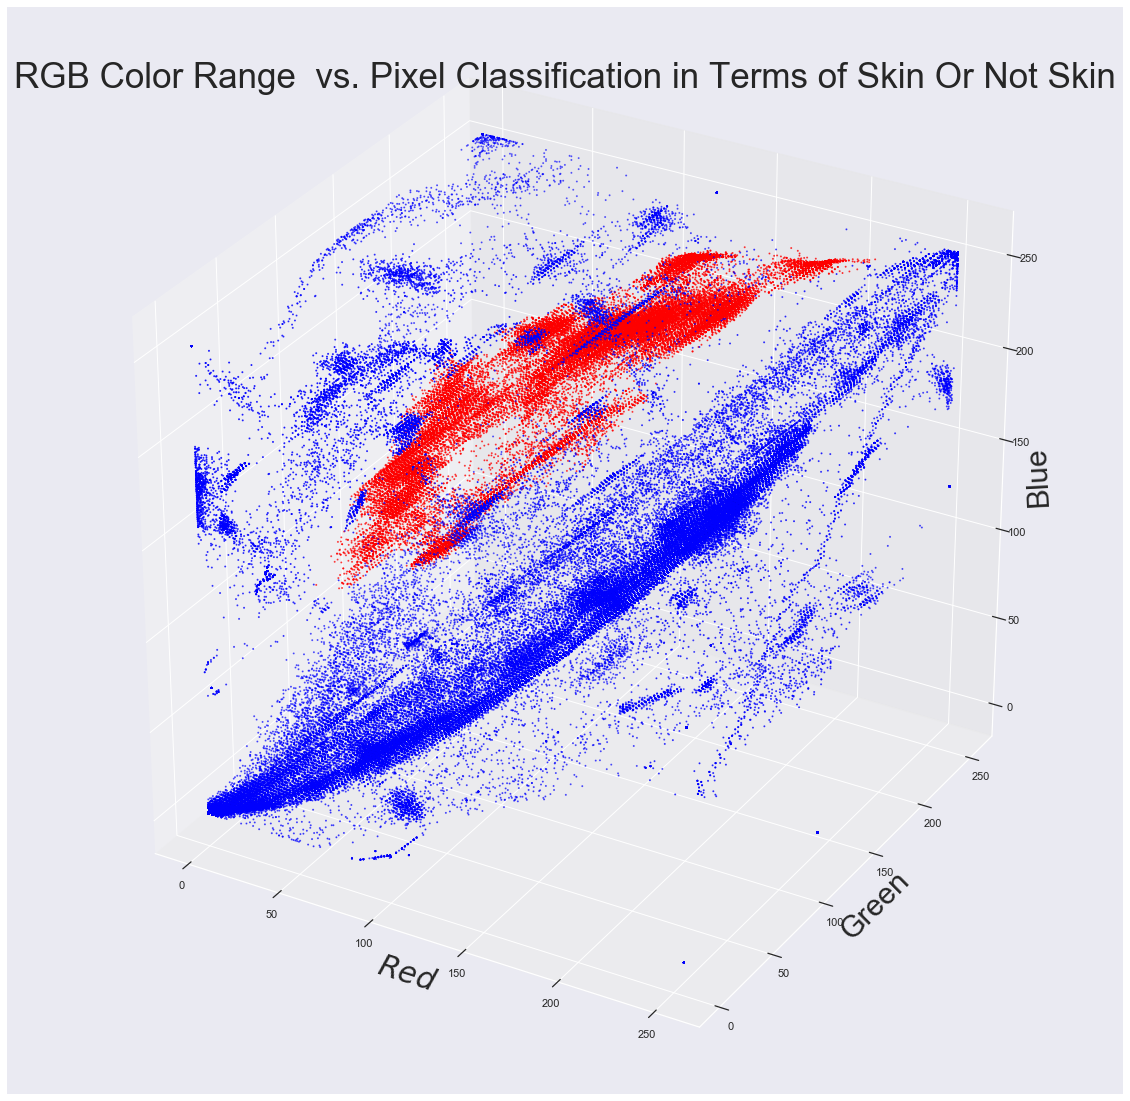

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure()


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

col = np.where(data["Skin or not"]==1,'red', 'blue')
ax.scatter(data["Red"], data["Green"], data["Blue"], c= col, s=1)
ax.set_xlabel('$Red$', fontsize=30, rotation=150)
ax.set_ylabel('Green', fontsize = 30)
ax.set_zlabel('Blue', fontsize=30, rotation=93)
ax.set_title('RGB Color Range  vs. Pixel Classification in Terms of Skin Or Not Skin',fontsize=35)
ax.grid()

### Since scikit methodology for support vector machines is slow (About O(features* sample^3 time) ), and since a sample size of almost 1 million is huge, I am getting a more reasonable and workable sample size. I decided to use 1 percent of the data since my machine can actually handle a sample of around 10 thousand. 

In [30]:
sample =data.sample(frac=0.01, replace=False, random_state=1)
sample.size

9804

# Now plotting my sample. This sample will be 3/4 training set 1/4 test set

<Figure size 432x288 with 0 Axes>

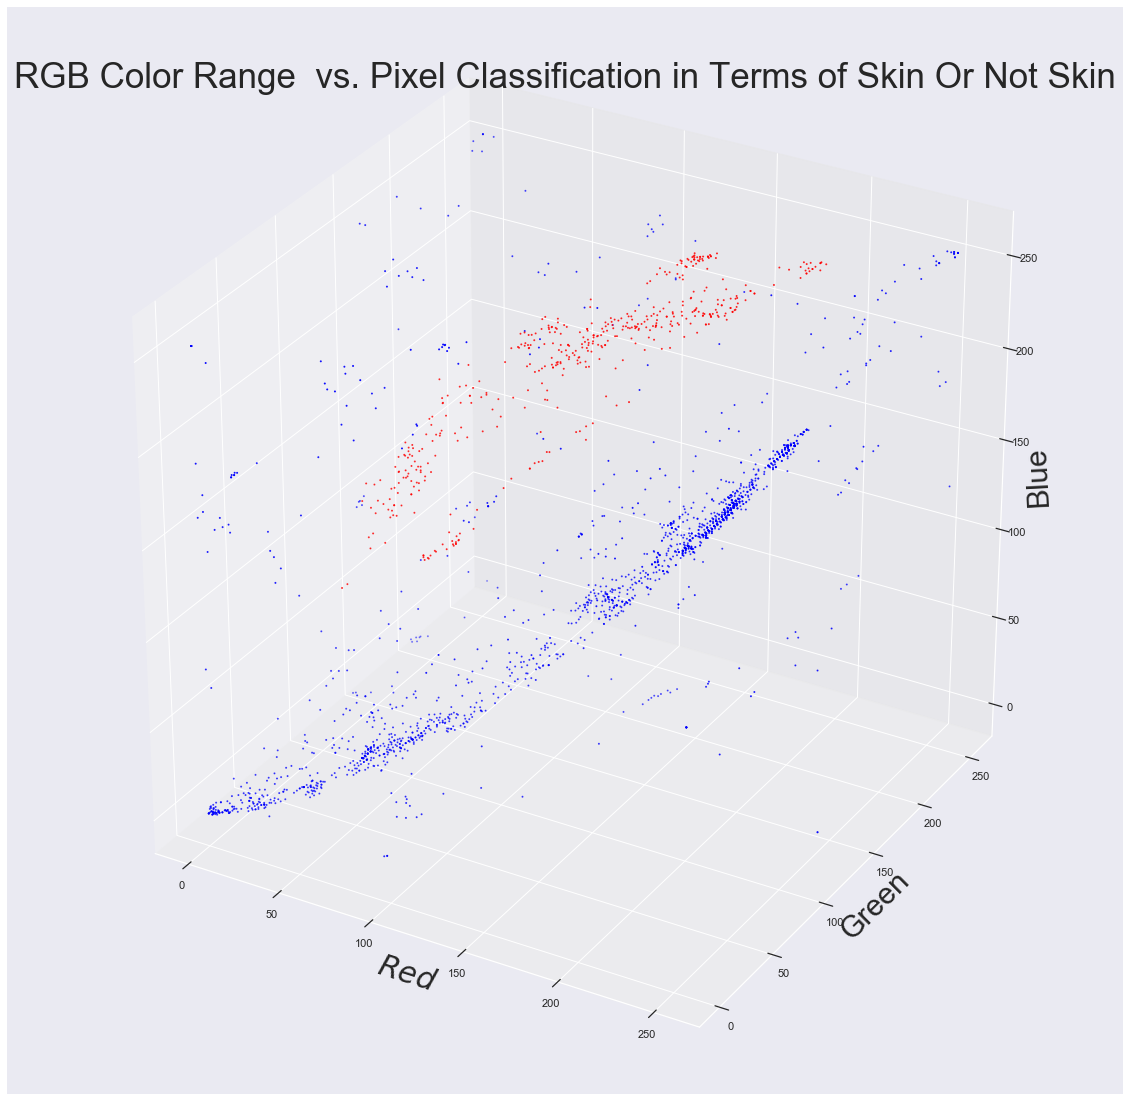

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure()


fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

col = np.where(sample["Skin or not"]==1,'red', 'blue')
ax.scatter(sample["Red"], sample["Green"], sample["Blue"], c= col, s=1)
ax.set_xlabel('$Red$', fontsize=30, rotation=150)
ax.set_ylabel('Green', fontsize = 30)
ax.set_zlabel('Blue', fontsize=30, rotation=93)
ax.set_title('RGB Color Range  vs. Pixel Classification in Terms of Skin Or Not Skin',fontsize=35)
ax.grid()

In [32]:
#this sets the red green and blue to be predictors and the y to be output/result
X = sample.iloc[:,0:3].values
y = sample.iloc[:,len(sample.iloc[0])-1].values

In [33]:
import numpy as np
from matplotlib import cm

In [34]:
#this splits into training and test sets  with 3/4 of the data training for the 1/4 test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [35]:
#this trains the support vector machine using default values/ not much tuning. 
#The gamma value decides how much variance in the support vector affects predictions
#As you will see, this large default value got inaccurate predictions/results. 

from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state=0, gamma=100)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
#train and predict with training set. 
#Once machine has learned from training set, use it to predict with test set
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

### As you can see, the initial untweaked svm algorithm has bad results for the confusion matrix. 

In [37]:
#print confusion matrixes. As you can see, on the test set, I got no false positives but I got 109 false negatives. 
#this model failed to predict accurately. I will tweak it. 

from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("Training set confusion matrix : \n"+str(cm_train))

print("Test set confusion matrix : \n"+str(cm_test))


Training set confusion matrix : 
[[ 351    0]
 [   0 1487]]
Test set confusion matrix : 
[[ 13 109]
 [  0 491]]


### For my own uses I printed the difference in test set actual values and predicted values. As you can see, 109 entries were predicted to be non skin that were actually skin.

In [38]:
import collections 
collections.Counter(y_test)

Counter({2: 491, 1: 122})

In [39]:
collections.Counter(y_test_pred)

Counter({2: 600, 1: 13})

## The below use of gridsearch iterates through possible c values and gamma values to find the best parameters.

### A further explanation of what those values mean. C is a value for the soft margin cost function which decides if data should be ignored or not in order to get a more accurate svm. Basically it's a margin where the support vector machine will make decisions on classifying data and make decisions about how much those points affect the model. Generally, it is good to vary the c value by factors of 10 according to sources. 

### Meanwhile, gamma is a parameter of the function used in the gbf kernel. I have to use the gbf kernel because my data is in 3 dimensions of red, green, and blue so it is best served by a Gaussian kernel. Basically, since the data is 3 dimensional the algorithm uses a Gaussian radial basis function for non linear svm classification. This function's gamma parameter affects how much support vectors in the Gaussian function can influence classification. If the data has a lot of variance like our model, a small gamma value is necessary because this means distance between the support vector and the datapoint will not matter as much and the support vector will still effectively influence the classication of the data. A small gamma is basically necessary for very spread out and variable data like this skin segmentation data where distance from support vectors might skew things and render the svm ineffective.

### My use of grid search automated testing of all of these parameters. I used these resources for creation of this function:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0

### This could have been done manually instead of iterating over with gridsearch. I could have compared accuracy of predictions for a lot of different variables but it is most accurate to use the grid search function for an exhaustive algorithmic look at the best parameters. Also, I decided to do 10 folds because this is a pretty standard value. I have used it before for clustering and many other machine learning tasks. It proved an effective number of folds as you will see that the svm got much better performance with the new c and gamma values. 

In [64]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [45]:
#outputs the best results for 10 folds in a support vector machine with several tested c and gamma values
svc_param_selection(X, y, 10)

{'C': 1, 'gamma': 0.001}

In [46]:
#I made a new support vector machine with these new c and gamma parameters, and used it on the training and test sets
classifier = SVC(C = 1.0, kernel = 'rbf', random_state=0, gamma=0.001)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

## Much better results:

### As you can see, my svm was now 100 percent successful with the test set. It only had 5 errors of false positives with the training set. I got much more accurate results by accounting for how much influence the support vectors should have. 

In [48]:

from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("Training set confusion matrix : \n"+str(cm_train))

print("Test set confusion matrix : \n"+str(cm_test))

Training set confusion matrix : 
[[ 351    0]
 [   5 1482]]
Test set confusion matrix : 
[[122   0]
 [  0 491]]
